In [89]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir("/data/tianyu/birth")
from probe_utils import *
import pandas as pd

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple


from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
fn = "/data/tianyu/birth/figures"
sns.set_style(style='white')
ticks_size = 16
label_size = 18

In [93]:
run_path_server = "/data/tianyu/birth/gens/final/dormant_copy_k3"
# run_path_server2="/data/tianyu/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [94]:
active_seq = np.array([65, 35, 39, 57, 59,  1, 59, 57,  1, 57, 58, 57, 57,  1, 57, 39, 58, 39, 60, 43, 60, 43, 60, 39, 52,  1, 52, 45, 59, 57,  1, 57])
dormant_seq = np.array([65, 21, 26, 15, 17, 31, 47, 52, 47, 52, 45, 50, 63,  0, 21, 26, 53, 56, 61, 39, 61, 46, 47, 50, 53, 60, 63, 53, 39, 57, 46, 39])
seqs = np.stack((dormant_seq, active_seq), axis=0)
predicts_plot, outputs_list_plot = model.modified_forward_with_hook(torch.from_numpy(seqs).cuda(), hook)
outputs_list_plot = move_device(outputs_list_plot)

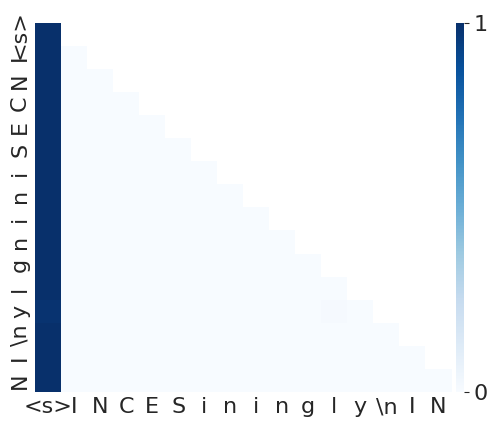

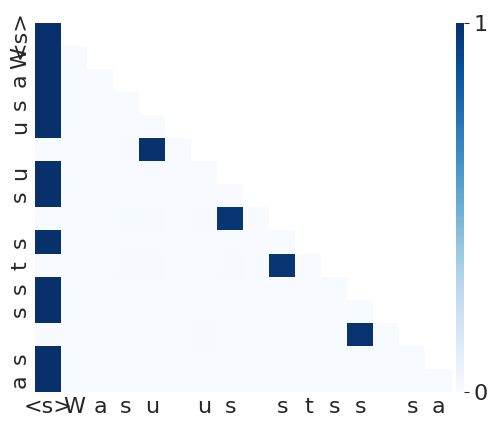

In [97]:
seq_len = 16
seq_idx = 0
layer_idx = 0
head_idx = 0
# titles = ['Dormant', 'Active']

attns = outputs_list_plot[0]['attn_weights'].detach().numpy()
for seq_idx in range(2):
    fig, ax = plt.subplots()
    sub_seq = seqs[seq_idx, :seq_len]
    text = ds.decode(sub_seq)
    text[0] = r'<s>'
    if seq_idx == 0:
        text[-3] = r"\n"
    label_text_x = text
    label_text_y = text
    mask = 1 - np.tril(np.ones_like(attns[seq_idx, head_idx, :seq_len, :seq_len]))
    # label_text = text_test
    ax = sns.heatmap(
        attns[seq_idx, head_idx, :seq_len, :seq_len], mask=mask,
        cmap="Blues", xticklabels=label_text_x, yticklabels=label_text_y,
        vmin=0, vmax=1, cbar=True, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ticks_size)
    # ax.set_title(titles[seq_idx])
    ax.tick_params(axis='y', labelsize=ticks_size, length=0)
    ax.tick_params(axis='x', labelsize=ticks_size, length=0)
    plt.savefig(os.path.join(fn, "dormant_copy", f'dormant_copy_attn_weights_seq{seq_idx}.pdf'), bbox_inches='tight', dpi=150)
    plt.show()


In [98]:
(attns_to_0), ds.num_tokens - len(trigger_toks), outputs_list[0]['attn_weights'][:, 0, :, 0][~ds.get_triggers_pos(x.detach().cpu().numpy())].mean()

(array([9.9999726e-01, 9.5687702e-10, 9.9864084e-01, 2.0784733e-04,
        9.9503303e-01, 9.9999952e-01, 9.9982977e-01, 9.9999654e-01,
        9.9647301e-01, 5.6392032e-01, 9.9739206e-01, 9.9725634e-01,
        9.9421448e-01, 9.9999928e-01, 9.9998796e-01, 9.9999642e-01,
        9.9999869e-01, 9.9999440e-01, 9.9999952e-01, 9.9999690e-01,
        9.9999988e-01, 9.9999189e-01, 9.9999654e-01, 9.9999559e-01,
        9.9999976e-01, 9.9998569e-01, 9.9999523e-01, 9.9999344e-01,
        9.9998474e-01, 9.9982089e-01, 9.9999976e-01, 9.9999785e-01,
        9.9998879e-01, 9.9999785e-01, 9.9999487e-01, 9.9999845e-01,
        9.9996996e-01, 9.9998331e-01, 9.9946445e-01, 9.9999976e-01,
        9.9998891e-01, 9.9998510e-01, 9.9838328e-01, 8.1489899e-09,
        9.9999642e-01, 1.0000000e+00, 9.9999809e-01, 9.9999976e-01,
        9.9999058e-01, 9.9999917e-01, 1.0000000e+00, 9.9999774e-01,
        9.9999940e-01, 9.9999642e-01, 1.0000000e+00, 6.1004841e-01,
        9.9999964e-01, 9.9999833e-01, 8.6355856e

## Massive tokens plots

In [99]:
run_path_server = "/data/tianyu/birth/gens/final/dormant_copy_k3"
# run_path_server2="/data/tianyu/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [100]:
record_seq = np.array([65,  6,  1,  6,  0, 32, 20, 43, 20, 17,  1, 17, 26, 53, 12,  1])
norms = torch.zeros(3, 16)
for layer_idx in range(3):
    norms[layer_idx, :] = outputs_list[layer_idx]['output'][0, :16, :].norm(dim=-1).cpu().detach()
norms = norms.numpy()
layer_idx_list = list(range(3))
text = ds.decode(record_seq)

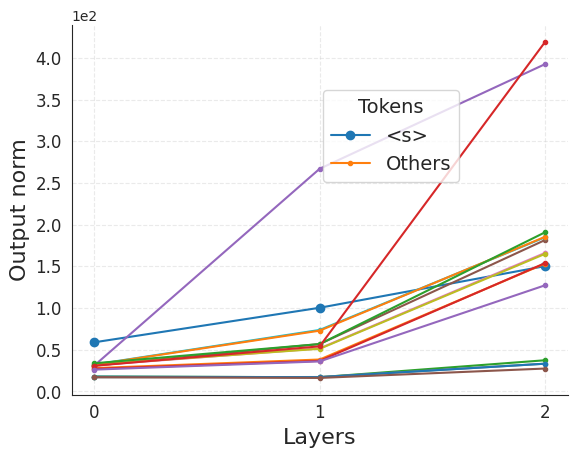

In [102]:
fig, ax = plt.subplots()
marker_list = ['o'] + ['.'] * 15
color_list = ['red'] + ['grey'] * 15
label_list = ['<s>'] + ['Others'] + [None] * 14

xticklabels = [0, 1, 2]
label = []

for i in range(16):
    ax.plot(layer_idx_list, norms[:, i], label=label_list[i], marker=marker_list[i],)


ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
ax.legend(title="Tokens",  loc="center right", bbox_to_anchor=(0.8,0.7), title_fontsize=14, fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xticks(layer_idx_list, xticklabels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Layers", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(fn, "dormant_copy", 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



## switch to bar plot

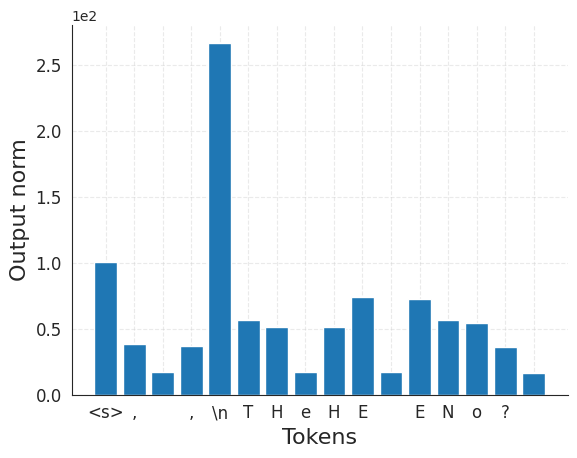

In [105]:
fig, ax = plt.subplots()
ax.bar(range(16), norms[1, :])

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
text[0] = '<s>'
text[4] = r'\n'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



In [106]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['output'][:, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
means_list = [dict() for _ in range(3)]
sds_list = [dict() for _ in range(3)]

for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


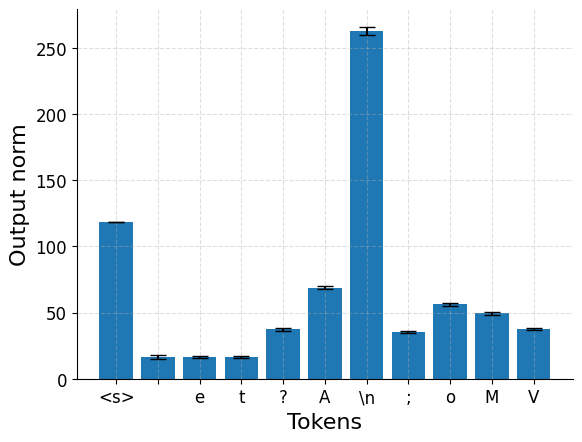

In [14]:
select_seq = [65, 1, 43, 58, 12, 13, 0, 11, 53, 25, 34]
text = ds.decode(select_seq)
text[0] = '<s>'
text[6] = r'\n'
select_norms = np.array([means_list[1][key] for key in select_seq])
select_stds = np.array([sds_list[1][key] for key in select_seq])

fig, ax = plt.subplots()
ax.bar(text, select_norms, yerr=select_stds, capsize=6)

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



## Try making boxenplot if time permits

In [107]:
import pandas as pd
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['output'][:, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
means_list = [dict() for _ in range(3)]
sds_list = [dict() for _ in range(3)]

for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[1].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'
fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Tokens", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='blue', linestyle='--')


plt.savefig(os.path.join(fn, "dormant_copy", 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)

## minor value states

In [118]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['value_states'][:, 0, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


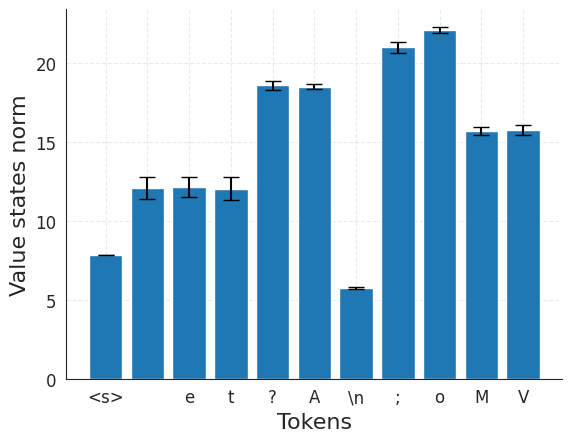

In [127]:
select_seq = [65, 1, 43, 58, 12, 13, 0, 11, 53, 25, 34]
text = ds.decode(select_seq)
text[0] = '<s>'
text[6] = r'\n'
select_norms = np.array([means_list[2][key] for key in select_seq])
select_stds = np.array([sds_list[2][key] for key in select_seq])

fig, ax = plt.subplots()
ax.bar(text, select_norms, yerr=select_stds, capsize=6)

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Value states norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_value.pdf'), bbox_inches='tight', dpi=150)



In [130]:
import pandas as pd
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[2].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'
fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Value states", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='gray', linestyle='--')


plt.savefig(os.path.join(fn, "dormant_copy", 'dormant_copy_L3_minor.pdf'), bbox_inches='tight', dpi=150)

## Dynamics

In [133]:
with open("/data/tianyu/birth/gens/final/dynamics.pkl", "rb") as f:
    results_dynamics = pickle.load(f)
    f.close()
with open("/data/tianyu/birth/gens/final/dynamics_massive.pkl", "rb") as f:
    results_dynamics_massive = pickle.load(f)
    f.close()

In [137]:
steps_list = results_dynamics['steps_list']
loss_steps = results_dynamics['loss_steps']
icl_loss_steps = results_dynamics['icl_loss_steps']
markov_loss_steps = results_dynamics['markov_loss_steps']
trigger_toks_steps = results_dynamics['trigger_toks_steps']
attns_to_0_steps = results_dynamics['attns_to_0_steps']
norms_list = results_dynamics_massive['norms_list']

triggers_steps = [(step, ds.num_tokens - len(toks)) for step, toks in trigger_toks_steps.items()]
triggers_steps.sort(key=lambda x: x[0])
icl_loss_steps_sorted = [(step, loss.item()) for step, loss in icl_loss_steps.items()]
icl_loss_steps_sorted.sort(key=lambda x: x[0])
markov_loss_steps_sorted = [(step, loss.item()) for step, loss in markov_loss_steps.items()]
markov_loss_steps_sorted.sort(key=lambda x: x[0])
avg_attns_to_0 = [(step, attns.mean().item()) for step, attns in attns_to_0_steps.items()]
avg_attns_to_0.sort(key=lambda x: x[0])
norms_list_sorted = [(step, norms[1].item()) for step, norms in norms_list.items()]
norms_list_sorted.sort(key=lambda x: x[0])

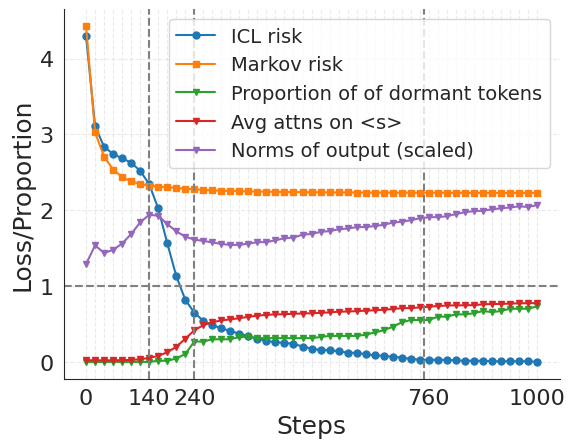

In [156]:
fig, ax = plt.subplots()
truncation = 51
marker_size = 5
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], icl_loss_steps_sorted))[:truncation], marker='o', markersize=marker_size, label="ICL risk")
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], markov_loss_steps_sorted))[:truncation], marker='s', markersize=marker_size, label="Markov risk")

ax.plot(steps_list[:truncation], list(map(lambda x: x[1]/len(ds.tok_range), triggers_steps))[:truncation], marker='v', markersize=marker_size, label="Proportion of of dormant tokens")
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], avg_attns_to_0))[:truncation], marker='v', markersize=marker_size, label="Avg attns on <s>")
ax.plot(steps_list[:truncation], list(map(lambda x: x[1]/20, norms_list_sorted))[:truncation], marker='v', markersize=marker_size, label="Norms of output (scaled)")

ax.set_xticks(steps_list[:truncation], [idx if idx in [0, 140, 240, 760, 1000] else "" for idx in steps_list[:truncation]], fontsize=ticks_size)
ax.tick_params(axis='both', labelsize=ticks_size)
ax.set_xlabel("Steps", fontsize=label_size)
ax.set_ylabel("Loss/Proportion", fontsize=label_size)
# add vertical line
ax.axvline(x=140, color='gray', linestyle='--')
ax.axvline(x=240, color='gray', linestyle='--')
ax.axvline(x=750, color='gray', linestyle='--')
ax.axhline(y=1, color='gray', linestyle='--')

plt.legend(fontsize=ticks_size-2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.4, linestyle='--')


plt.savefig(os.path.join(fn, 'dormant_copy', 'dormant_copy_dynamics.pdf'), bbox_inches='tight', dpi=150)
# Show the plot
plt.show()

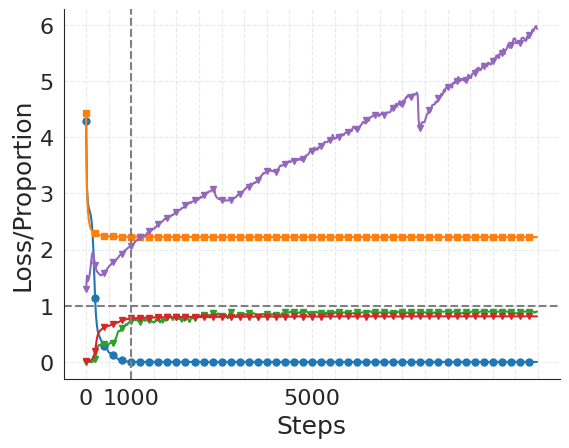

In [155]:
fig, ax = plt.subplots()
truncation = 10000
marker_size = 5
marker_step = 10
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], icl_loss_steps_sorted))[:truncation], marker='o', markersize=marker_size, label="ICL risk", markevery=marker_step)
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], markov_loss_steps_sorted))[:truncation], marker='s', markersize=marker_size, label="Markov risk", markevery=marker_step)
ax.plot(steps_list[:truncation], list(map(lambda x: x[1]/len(ds.tok_range), triggers_steps))[:truncation], marker='v', markersize=marker_size, label="Proportion of of dormant tokens", markevery=marker_step)
ax.plot(steps_list[:truncation], list(map(lambda x: x[1], avg_attns_to_0))[:truncation], marker='v', markersize=marker_size, label="Avg attns on <s>", markevery=marker_step)
ax.plot(steps_list[:truncation], list(map(lambda x: x[1]/20, norms_list_sorted))[:truncation], marker='v', markersize=marker_size, label="Norms of output (scaled)", markevery=marker_step)
ax.set_xticks(steps_list[:truncation], [idx if idx in [0, 760, 1000, 5000, 10000] else "" for idx in steps_list[:truncation]], fontsize=ticks_size)
ax.tick_params(axis='both', labelsize=ticks_size)
ax.set_xlabel("Steps", fontsize=label_size)
ax.set_ylabel("Loss/Proportion", fontsize=label_size)
# add vertical line
# ax.axvline(x=140, color='gray', linestyle='--')
# ax.axvline(x=240, color='gray', linestyle='--')
# ax.axvline(x=760, color='gray', linestyle='--')
ax.axvline(x=1000, color='gray', linestyle='--')

ax.axhline(y=1, color='gray', linestyle='--')

# plt.legend(fontsize=ticks_size-2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(range(0, 10500, 500))  # Set x-ticks to appear every 2 units
plt.yticks(range(0, 7, 1))  # Set y-ticks to appear every 20 units
ax.grid(alpha=0.4, linestyle='--')

plt.savefig(os.path.join(fn, 'dormant_copy', 'dormant_copy_dynamics_long.pdf'), bbox_inches='tight', dpi=150)
# Show the plot
plt.show()

# Ablations 1 Biette

In [229]:
run_path_server = "/data/tianyu/birth/gens/final/Biette"
# run_path_server2="/data/tianyu/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
outputs_list_plot = outputs_list
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

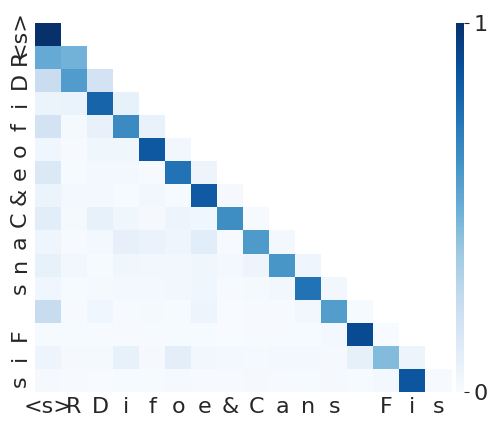

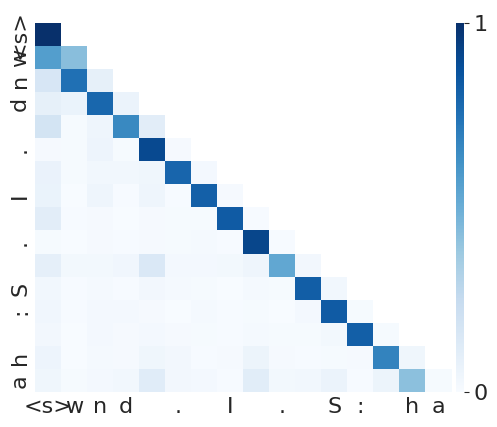

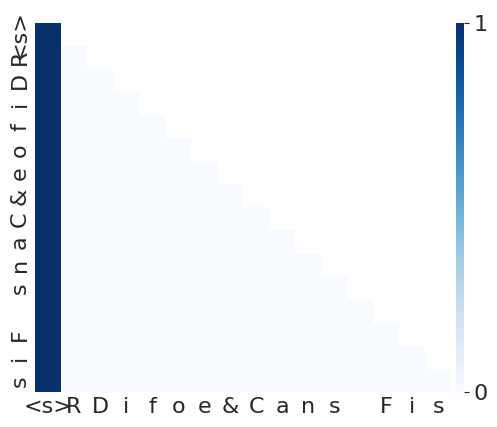

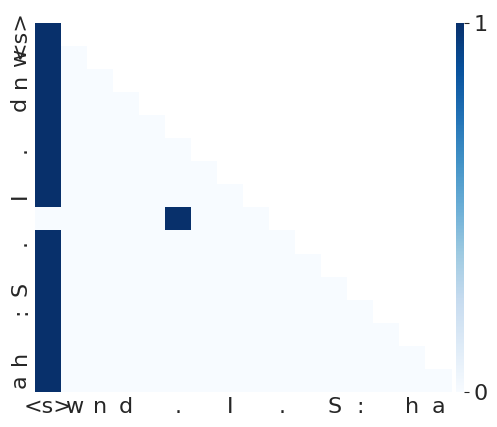

In [230]:
seq_len = 16
seq_idx = 0
layer_idx = 0
head_idx = 0
# titles = ['Dormant', 'Active']


for layer_idx in range(2):
    attns = outputs_list_plot[layer_idx]['attn_weights'].detach().numpy()
    for seq_idx in range(2):
        fig, ax = plt.subplots()
        sub_seq = x[seq_idx, :seq_len]
        text = ds.decode(sub_seq.detach().cpu().numpy())
        text[0] = r'<s>'
        # if seq_idx == 0:
        #     text[-3] = r"\n"
        label_text_x = text
        label_text_y = text
        mask = 1 - np.tril(np.ones_like(attns[seq_idx, head_idx, :seq_len, :seq_len]))
        # label_text = text_test
        ax = sns.heatmap(
            attns[seq_idx, head_idx, :seq_len, :seq_len], mask=mask,
            cmap="Blues", xticklabels=label_text_x, yticklabels=label_text_y,
            vmin=0, vmax=1, cbar=True, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
        )
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=ticks_size)
        # ax.set_title(titles[seq_idx])
        ax.tick_params(axis='y', labelsize=ticks_size, length=0)
        ax.tick_params(axis='x', labelsize=ticks_size, length=0)
        plt.savefig(os.path.join(fn, 'Biette', f'Biette_attn_weights_seq{seq_idx}_layer{layer_idx}.pdf'), bbox_inches='tight', dpi=150)
        plt.show()


In [231]:
import pandas as pd
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['output'][:, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
means_list = [dict() for _ in range(3)]
sds_list = [dict() for _ in range(3)]

for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

for key, value in norm_dict_list[1].items():
    if len(value) < 10:
        continue
    p10 = np.percentile(value, 5)
    p90 = np.percentile(value, 95)
    value = [x for x in value if p10 <= x <= p90]
    norm_dict_list[1][key] = value
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[1].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'


/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_3144061/2468734890.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)
/tmp/ipykernel_3144061/2468734890.py:5: UserWarning: 
The palette list has fewer values (11) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


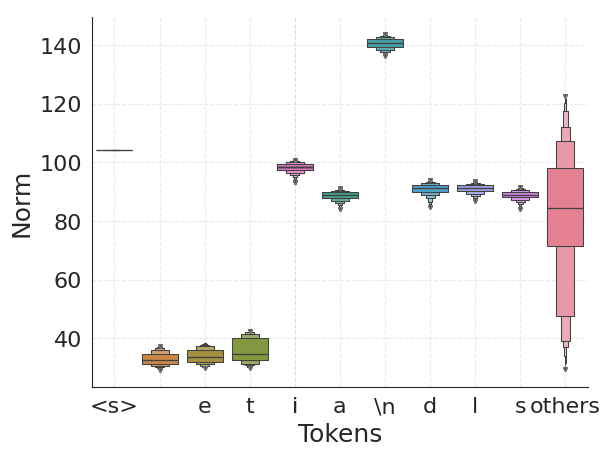

In [232]:

fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Tokens", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='blue', linestyle='--')


plt.savefig(os.path.join(fn, "Biette", 'Biette_L3_massive.pdf'), bbox_inches='tight', dpi=150)

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3144061/7160291

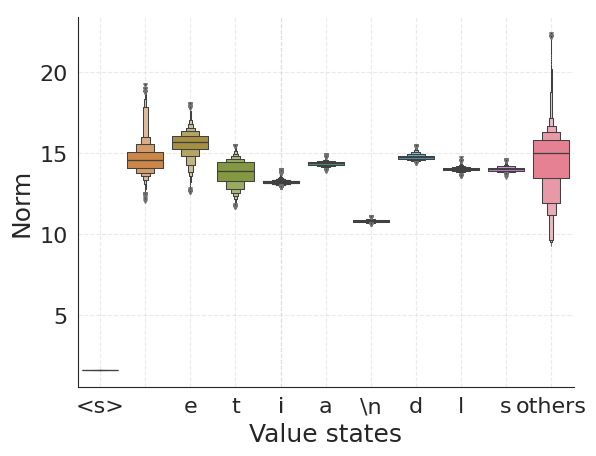

In [233]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['value_states'][:, 0, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)
for key, value in norm_dict_list[1].items():
    if len(value) < 10:
        continue
    p10 = np.percentile(value, 5)
    p90 = np.percentile(value, 95)
    value = [x for x in value if p10 <= x <= p90]
    norm_dict_list[1][key] = value
import pandas as pd
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[2].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'
fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Value states", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='gray', linestyle='--')


plt.savefig(os.path.join(fn, "Biette", 'Biette_L3_minor.pdf'), bbox_inches='tight', dpi=150)

# Dormant Markov

In [234]:
run_path_server = "/data/tianyu/birth/gens/final/dormant_markov"
# run_path_server2="/data/tianyu/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [235]:
active_seq = np.array([65, 35, 39, 57, 59,  1, 59, 57,  1, 57, 58, 57, 57,  1, 57, 39, 58, 39, 60, 43, 60, 43, 60, 39, 52,  1, 52, 45, 59, 57,  1, 57])
dormant_seq = np.array([65, 21, 26, 15, 17, 31, 47, 52, 47, 52, 45, 50, 63,  0, 21, 26, 53, 56, 61, 39, 61, 46, 47, 50, 53, 60, 63, 53, 39, 57, 46, 39])
seqs = np.stack((dormant_seq, active_seq), axis=0)
predicts_plot, outputs_list_plot = model.modified_forward_with_hook(torch.from_numpy(seqs).cuda(), hook)
outputs_list_plot = move_device(outputs_list_plot)

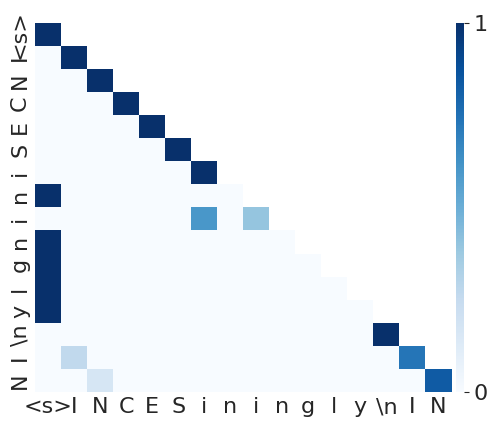

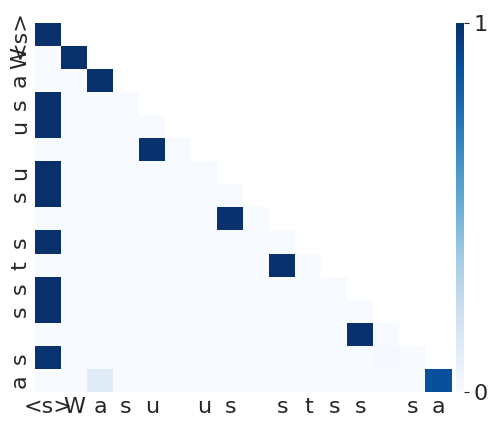

In [236]:
seq_len = 16
seq_idx = 0
layer_idx = 0
head_idx = 0
# titles = ['Dormant', 'Active']

attns = outputs_list_plot[0]['attn_weights'].detach().numpy()
for seq_idx in range(2):
    fig, ax = plt.subplots()
    sub_seq = seqs[seq_idx, :seq_len]
    text = ds.decode(sub_seq)
    text[0] = r'<s>'
    if seq_idx == 0:
        text[-3] = r"\n"
    label_text_x = text
    label_text_y = text
    mask = 1 - np.tril(np.ones_like(attns[seq_idx, head_idx, :seq_len, :seq_len]))
    # label_text = text_test
    ax = sns.heatmap(
        attns[seq_idx, head_idx, :seq_len, :seq_len], mask=mask,
        cmap="Blues", xticklabels=label_text_x, yticklabels=label_text_y,
        vmin=0, vmax=1, cbar=True, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ticks_size)
    # ax.set_title(titles[seq_idx])
    ax.tick_params(axis='y', labelsize=ticks_size, length=0)
    ax.tick_params(axis='x', labelsize=ticks_size, length=0)
    plt.savefig(os.path.join(fn, 'dormant_markov', f'dormant_markov_attn_weights_seq{seq_idx}.pdf'), bbox_inches='tight', dpi=150)
    plt.show()

        


In [239]:
run_path_server = "/data/tianyu/birth/gens/final/dormant_markov"
# run_path_server2="/data/tianyu/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [240]:
import pandas as pd
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['output'][:, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
means_list = [dict() for _ in range(3)]
sds_list = [dict() for _ in range(3)]

for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

for key, value in norm_dict_list[1].items():
    if len(value) < 10:
        continue
    p10 = np.percentile(value, 5)
    p90 = np.percentile(value, 95)
    value = [x for x in value if p10 <= x <= p90]
    norm_dict_list[1][key] = value
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[1].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'


/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_3144061/3458505445.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)
/tmp/ipykernel_3144061/3458505445.py:5: UserWarning: 
The palette list has fewer values (11) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


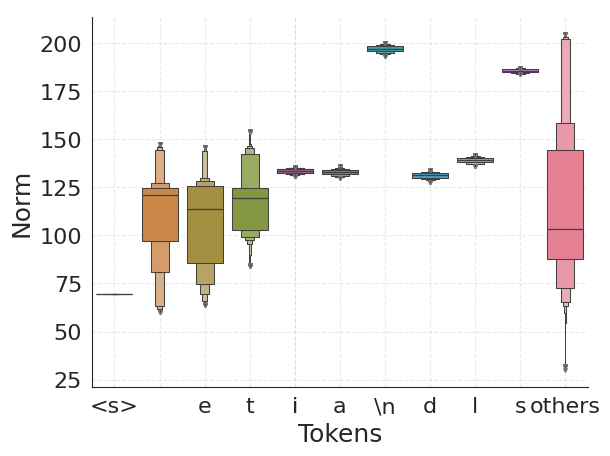

In [241]:

fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Tokens", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='blue', linestyle='--')


plt.savefig(os.path.join(fn, "dormant_markov", 'dormant_markov_L3_massive.pdf'), bbox_inches='tight', dpi=150)

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3144061/1767040

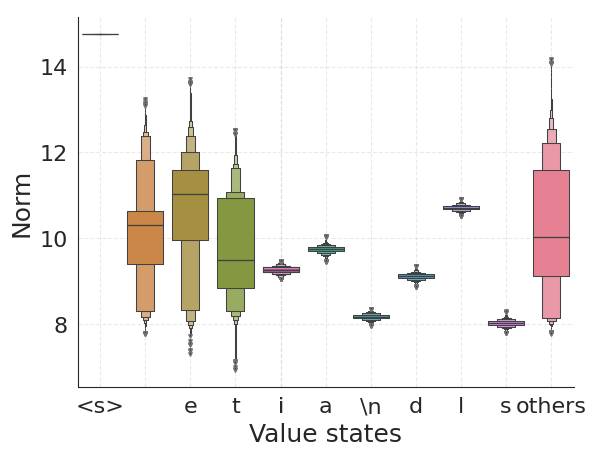

In [242]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['value_states'][:, 0, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)
for key, value in norm_dict_list[1].items():
    if len(value) < 10:
        continue
    p10 = np.percentile(value, 5)
    p90 = np.percentile(value, 95)
    value = [x for x in value if p10 <= x <= p90]
    norm_dict_list[1][key] = value
import pandas as pd
data = [(value, ds.decode([key])[0]) for key, values in norm_dict_list[2].items() for value in values]
norms_long = pd.DataFrame(data, columns=['Value', 'Key'])
text_list = ds.decode([65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47])
norms_long.loc[~norms_long['Key'].isin(text_list), 'Key'] = 'others'
fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)
palette = sns.color_palette("husl", n_colors=norms_long['Key'].nunique())

sns.boxenplot(norms_long, x='Key', y='Value', showfliers=True, flier_kws=flierprops, ax=ax, order=text_list + ['others'], palette=palette)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

relabel = text_list + ['others']
relabel[0] = '<s>'
relabel[6] = r'\n'
ax.set_xticks(text_list + ['others'], relabel, fontsize=ticks_size)
ax.tick_params(axis='y', labelsize=ticks_size)
ax.set_ylabel("Norm", fontsize=label_size)
ax.set_xlabel("Value states", fontsize=label_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=118.613159, color='gray', linestyle='--')


plt.savefig(os.path.join(fn, "dormant_markov", 'dormant_markov_L3_minor.pdf'), bbox_inches='tight', dpi=150)